# Annealing test
Compare 2 annealing strategies, noising and tempering. Then solve tempering Langevin SDE with diffrax and play with cooling (detempering) speed.

In [8]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
import numpyro.distributions as dist
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Annealing Tests")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch
save_dir = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024/03/04 18:34:41 INFO mlflow.tracking.fluent: Experiment with name 'Annealing Tests' does not exist. Creating a new experiment.


## Toy model

Define a simple model with normal prior and gaussian mixture likelihood.
Gaussian noising can then be computed analytically.

In [9]:
mean_prior = 0
var_prior = 9
var_mixt = 1

def mixture_model(dim=2, 
                  radius=3,
                  sigma=0,
                  noise_prior=True):
    mean_mixt = radius * jnp.ones(dim) / dim**0.5 # same euclidiean distance between modes for any dim
    if noise_prior:
        var_post = 1 / (1/var_prior + 1/var_mixt)
        mean_post = (mean_prior/var_prior + mean_mixt/var_mixt) * var_post
        var_post = var_post + sigma**2 # noise prior (and likelihood)
    else:
        var_mixtnoise = var_mixt + sigma**2 # noise likelihood only
        var_post = 1 / (1/var_prior + 1/var_mixtnoise)
        mean_post = (mean_prior/var_prior + mean_mixt/var_mixtnoise) * var_post
    # loc = jnp.zeros(dim)
    # loc = loc.at[0].set(radius)
    mode1 = dist.MultivariateNormal(loc= mean_post, covariance_matrix=jnp.eye(dim)*var_post)
    mode2 = dist.MultivariateNormal(loc=-mean_post, covariance_matrix=jnp.eye(dim)*var_post)
    cat = dist.Categorical(jnp.array([.75, .25]))
    mixture = dist.MixtureGeneral(cat, [mode1, mode2])
    mixt =  numpyro.sample('mixt', mixture)
    return mixt


sample_fn = vmap(lambda rng_key, model_kwargs: seed(mixture_model, rng_key)(**model_kwargs), in_axes=(0, None))
from numpyro.infer.util import log_density
def logp_fn(mixt_val, sigma, model_kwargs, temper_prior=True):
    logp = log_density(model=mixture_model, 
                    model_args=(), 
                    model_kwargs=model_kwargs, 
                    params={'mixt':mixt_val})[0]
    if temper_prior:
        var_post = 1 / (1/var_prior + 1/var_mixt)
        return logp * var_post / (var_post + sigma**2)
    else: 
        logprior = dist.MultivariateNormal(loc=mean_prior, covariance_matrix=jnp.eye(model_kwargs['dim'])*var_prior).log_prob(mixt_val)
        return (logp * var_mixt + logprior * sigma**2) / (var_mixt + sigma**2)

score_fn = grad(logp_fn, argnums=0)
logp_vfn = vmap(logp_fn, in_axes=(0, None, None, None))
score_vfn = vmap(score_fn, in_axes=(0, None, None, None))

def p_vfn(x, sigma, model_kwargs, temper_prior=True):
    return jnp.exp(logp_vfn(x, sigma, model_kwargs, temper_prior))
# logp_fn(jnp.array([[1],[2]]),sigma=0,model_kwargs={}),\
# logp_fn(jnp.array([[1,1],[2,2]]),sigma=0,model_kwargs={}),\
# logp_fn(jnp.array([1]),sigma=0,model_kwargs={}) + logp_fn(jnp.array([2]),sigma=0,model_kwargs={})

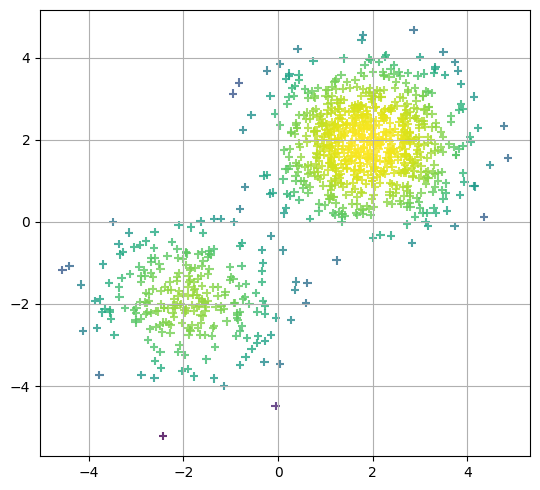

In [10]:
init_key = random.PRNGKey(0)
model_kwargs = {'dim':2, 'radius':3}
n_samples = 1000
samples = sample_fn(random.split(init_key, n_samples), model_kwargs)
sigma = 0
logps = logp_vfn(samples, sigma, model_kwargs, True)
scores = score_vfn(samples, sigma, model_kwargs, True)

plt.figure(figsize=(5.5,5))
plt.scatter(*samples[:, :2].T, c=logps, marker='+', alpha=.8)
plt.grid()
plt.tight_layout()
plt.show();

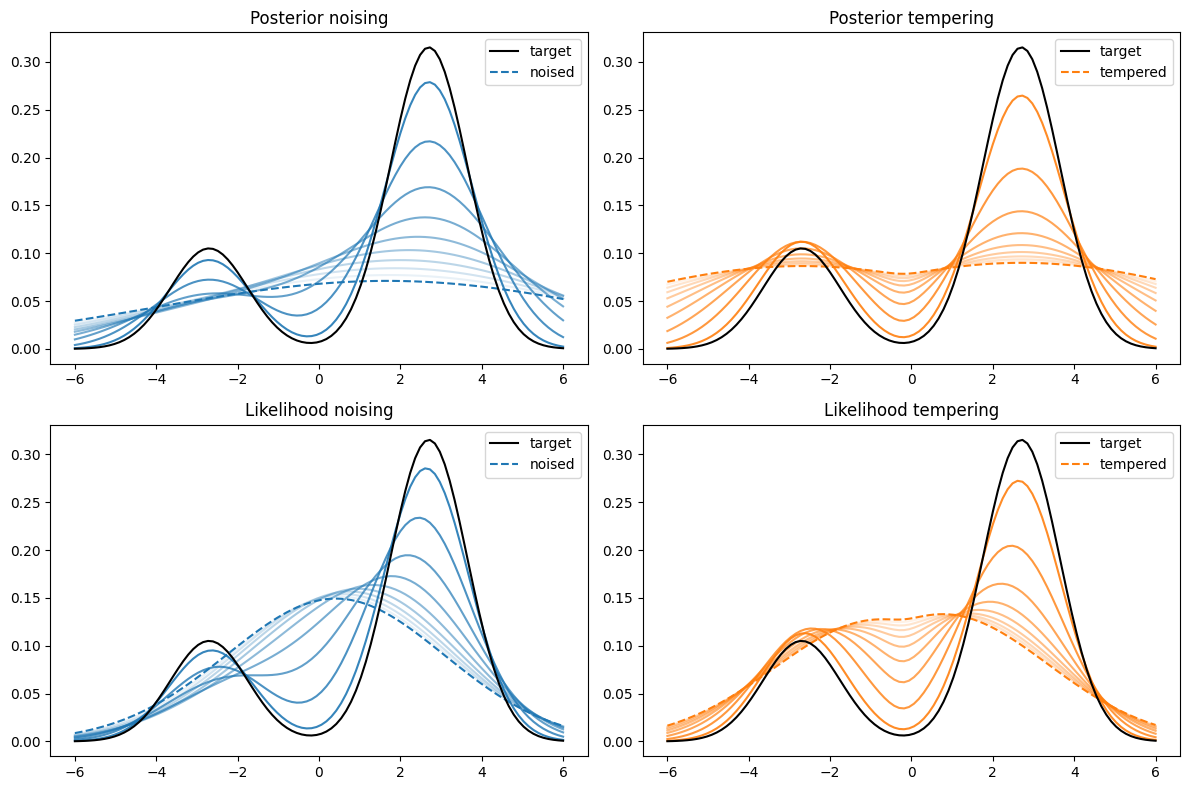

In [11]:
def plot_tempnoise(xs, border, model_kwargs, sigmas, noise, noise_prior):
    model_kwargs['noise_prior'] = noise_prior
    model_kwargs['sigma'] = 0
    plt.plot(xs, p_vfn(xs, 0, model_kwargs), 'k', label='target', zorder=np.inf)
    for i_sigma, sigma in enumerate(sigmas):
        if noise:
            color='C0'
            model_kwargs['sigma'] = sigma
            temper = 0
            label = "noised"
        else:
            color='C1'
            model_kwargs['sigma'] = 0
            temper = sigma
            label = "tempered"
        # tempered
        pdf_temp = p_vfn(xs, temper, model_kwargs, temper_prior=noise_prior)
        if not noise:
            pdf_temp = pdf_temp / (2* border * pdf_temp.mean())
        if i_sigma != len(sigmas)-1:
            alpha = float(1-sigma/max(sigmas))
            label=None
        else:
            alpha = 1
            color += '--'
        plt.plot(xs, pdf_temp, color, alpha=alpha, label=label)
        plt.legend()

# from scipy.integrate import simps # XXX
model_kwargs = {'dim':1, 'radius':3, 'sigma':0}
border = 2*model_kwargs['radius']
xs = jnp.linspace(-border,border,100)
sigmas = jnp.linspace(0.5,5,10)

plt.figure(figsize=(12,8))
plt.subplot(221)
plot_tempnoise(xs, border, model_kwargs, sigmas, noise=True, noise_prior=True)
plt.title("Posterior noising")
plt.subplot(222)
plot_tempnoise(xs, border, model_kwargs, sigmas, noise=False, noise_prior=True)
plt.title("Posterior tempering")
plt.subplot(223)
plot_tempnoise(xs, border, model_kwargs, sigmas, noise=True, noise_prior=False)
plt.title("Likelihood noising")
plt.subplot(224)
plot_tempnoise(xs, border, model_kwargs, sigmas, noise=False, noise_prior=False)
plt.title("Likelihood tempering")
plt.tight_layout()
mlflow.log_figure(plt.gcf(), "noising_vs_tempering.svg")
plt.show();

## Sampling from SDE

In [27]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, ReversibleHeun
t0, t1 = 5., 0.
model_kwargs = {'dim':2, 'radius':2, 'sigma':0}
drift = lambda t, y, args: - 0.5 * score_fn(y, t/t0, model_kwargs) # Now sigma is a function of time
diffusion = lambda t, y, args: jnp.ones_like(y)
solver = Euler()
saveat = SaveAt(ts=jnp.linspace(t0,t1))

@jax.jit
@jax.vmap
def get_samples(y, seed):
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-4, shape=(), key=seed)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  return diffeqsolve(terms, solver, t0, t1, dt0=-0.001, y0=y, max_steps=10_000, saveat=saveat).ys

In [28]:
model_kwargs = {'dim':1, 'radius':3, 'sigma':0}
n_samples = 100_000
init_samples = sample_fn(random.split(init_key, n_samples), model_kwargs)

res = get_samples(init_samples, random.split(random.PRNGKey(8), n_samples))

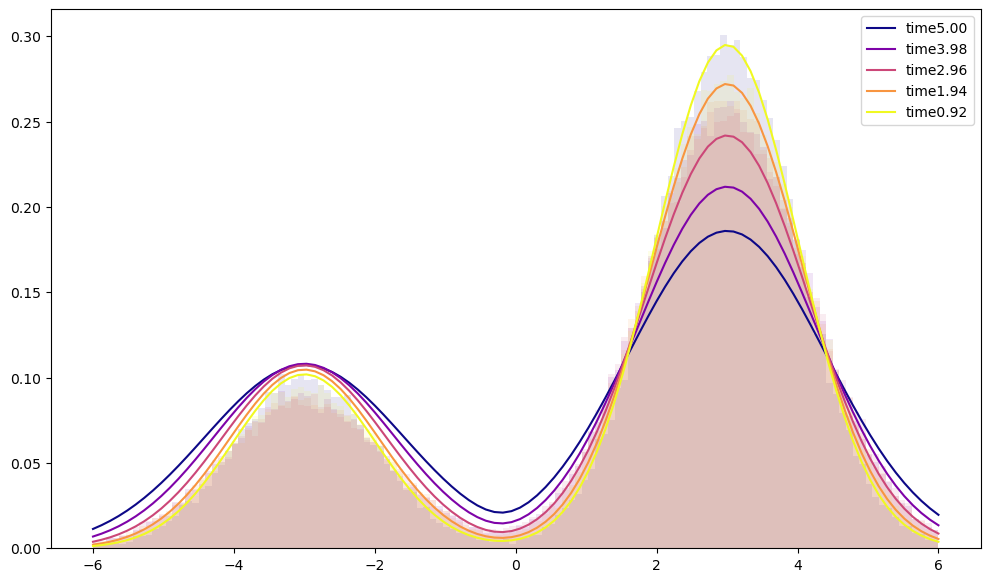

In [ ]:
# T=5
colors = plt.cm.plasma(np.linspace(0,1,5))
border = 2*model_kwargs['radius']
xs = jnp.linspace(-border,border,100)

plt.figure(figsize=[12,7])
for i,t in enumerate(saveat.subs.ts[::10]):
  # posterior = make_likelihood(t/t0).prob(x**2)*make_prior(t/t0).prob(x)
  model_kwargs['sigma'] = 0
  pdf_temp = p_vfn(xs, t/t0, model_kwargs)
  pdf_temp = pdf_temp / (2* border * pdf_temp.mean())
  plt.plot(xs, pdf_temp, color=colors[i], label=f"{t=:.2f}")
  plt.hist(res[:,i*10,0],128,range=[-border,border], density=True,alpha=0.1,color=colors[i]);
plt.legend();

## Minimal Diffrax with Numpyro model example

In [28]:
from montecosmo.utils import get_simulator, get_logp_fn, get_score_fn

from numpyro import sample
import numpyro.distributions as dist
def test_model(noise=0):
    a = sample('a', dist.Normal(0,1))
    b = sample('b', dist.Normal(jnp.zeros(2)+a, (jnp.ones(2)+noise**2)**.5))
    return b

simulator = get_simulator(test_model)
n_samples = 5
samples = simulator(n_samples)
logp_fn, score_fn = get_logp_fn(test_model), get_score_fn(test_model) 

In [68]:
# vmap(logp_fn)(samples, model_kwargs={'noise':jnp.ones(n_samples)})
# vmap(logp_fn)(samples, {'noise':1})
vmap(logp_fn, in_axes=(0,None))(samples, {'noise':1})

Array([-3.9761682, -3.6602259, -5.0661564, -6.6304755, -4.239357 ],      dtype=float32)

In [54]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, ReversibleHeun
from jax.tree_util import tree_map, tree_flatten
from jax.flatten_util import ravel_pytree
from jax import  eval_shape

t0, t1 = 5, 0.
noise = lambda t: t/t0
drift = lambda t, y, args: tree_map(lambda x: -0.5 * x, score_fn(y, model_kwargs={'noise':noise(t)}))
diffusion = lambda t, y, args: tree_map(lambda x: jnp.ones_like(x), y)
solver = Euler()
ts = jnp.linspace(t0,t1,100)
saveat = SaveAt(ts=ts)

sample_shape_struct = eval_shape(lambda x:{name: x[name][0] for name in x.keys()}, samples)

@jit
@vmap
def get_samples(y, seed):
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-4, shape=sample_shape_struct, key=seed)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  return diffeqsolve(terms, solver, t0, t1, dt0=-0.001, y0=y, max_steps=10_000, saveat=saveat).ys

In [55]:
res = get_samples(samples, random.split(random.PRNGKey(8), n_samples))

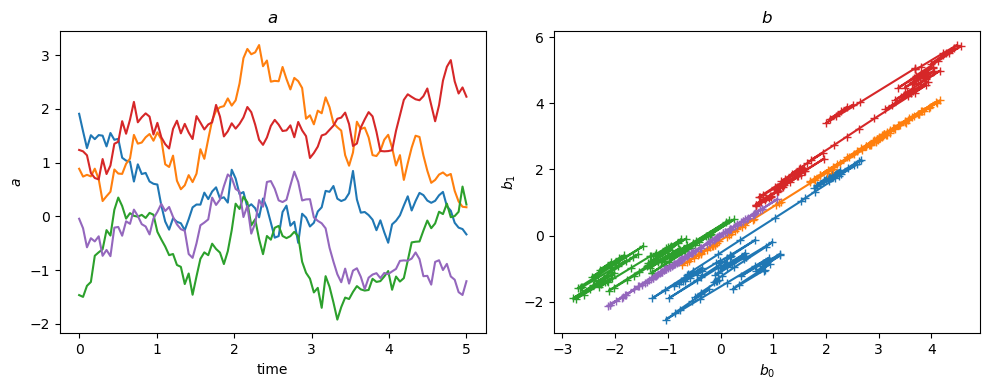

In [69]:
plt.figure(figsize=(10,4))
plt.subplot(121)
name, val = list(res.items())[0]
plt.plot(ts, val.T, label=name)
plt.xlabel('time'), plt.ylabel('$'+name+'$'), plt.title('$'+name+'$')
name, val = list(res.items())[1]
plt.subplot(122)
plt.plot(val[:,:,0].T, val[:,:,1].T, marker='+')
plt.xlabel('$'+name+'_0$'), plt.ylabel('$'+name+'_1$'), plt.title('$'+name+'$')
plt.tight_layout(), plt.show();

In [70]:
samples0 = {name: samples[name][0] for name in samples.keys()} # for debugging
logp_fn(samples0), score_fn(samples0),\
drift(0, samples0, ()), diffusion(0, samples0, ())

(Array(-3.752724, dtype=float32),
 {'a': Array(0.75482035, dtype=float32),
  'b': Array([-1.1556833 ,  0.73702586], dtype=float32)},
 {'a': Array(-0.37741017, dtype=float32),
  'b': Array([ 0.57784164, -0.36851293], dtype=float32)},
 {'a': Array(1., dtype=float32), 'b': Array([1., 1.], dtype=float32)})

## Annealing Poisson
When annealing Normal, wether we renormalize the tempered likelihood so it is still a proba, or not, change nothing with respect to mean.
For Poisson, one the likelihood is tempered, we can have a partition function that depends on both tempering and intensity which make this function a proba. Or we can not do so.

In general, tempering policy just set the likelihood to some power, without making it a proba.

For Poisson 
$$X \sim \frac{\mathcal P(\beta \lambda)} {\beta} \iff p_X(x \mid \lambda, \beta) = e^{-\beta \lambda} \frac{(\beta \lambda )^{\beta x}}{(\beta x)!} = \mathcal P(\beta x \mid \beta \lambda)$$
for the counting measure supported on all the $x \in \mathbb R$ such that $\beta x \in \mathbb N$ (i.e. $x \in \frac 1 \beta \mathbb N$), and we have
$$p_X(x \mid \lambda, \beta) \propto_x  \mathcal P(x \mid \lambda)^\beta \simeq  \frac{1}{Z(\lambda, \beta)} \mathcal P(x \mid \lambda)^\beta$$

/tmp/ipykernel_17358/1917107111.py:40: RuntimeWarning: invalid value encountered in divide
  plt.plot(intenses, (temppart_unsc - temppart) / temppart, '--', color='purple', label='rel.err. t+p')
/tmp/ipykernel_17358/1917107111.py:41: RuntimeWarning: invalid value encountered in divide
  plt.plot(intenses, (temp_unsc - temppart) / temppart, 'r--', label='rel.err. t')


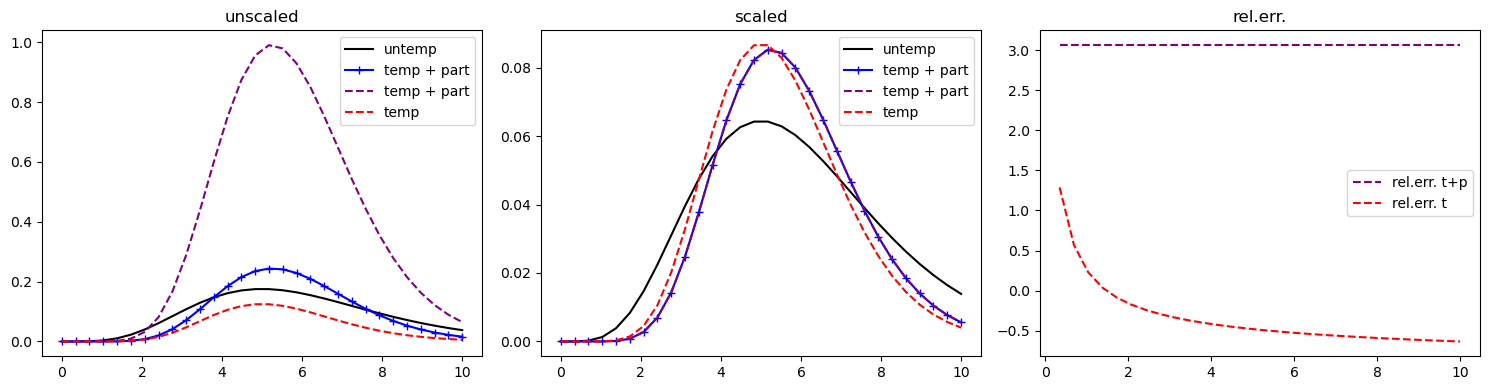

In [158]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0, 30, dtype=int)
poisson = lambda x, l: scipy.stats.poisson.pmf(x, l)

arr = []
parts = []
beta = 2
intenses = np.linspace(0.,10, 30)
for intens in intenses:
    base = np.maximum(poisson(x, intens), 0)**beta
    arr.append(base/base.sum())
    parts.append(base.sum())
arr = np.array(arr)
bases = np.array(parts)
xtoplot = 5

untemp = poisson(x[xtoplot], intenses)
temppart = arr[:,xtoplot]
temppart_unsc = poisson(beta * x[xtoplot], beta * intenses) / parts
temp_unsc = poisson(beta * x[xtoplot], beta * intenses)
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('unscaled')
plt.plot(intenses, untemp, 'k-', label='untemp')
plt.plot(intenses, temppart, 'b+-', label='temp + part')
plt.plot(intenses, temppart_unsc, '--', color='purple', label='temp + part')
plt.plot(intenses, temp_unsc, 'r--', label='temp')
plt.legend()
plt.subplot(132)
plt.title('scaled')
plt.plot(intenses, untemp/untemp.sum(), 'k-', label='untemp')
plt.plot(intenses, temppart/temppart.sum(), 'b+-', label='temp + part')
plt.plot(intenses, temppart_unsc/temppart_unsc.sum(), '--', color='purple', label='temp + part')
plt.plot(intenses, temp_unsc/temp_unsc.sum(), 'r--', label='temp')
plt.legend()
plt.subplot(133)
plt.title('rel.err.')
plt.plot(intenses, (temppart_unsc - temppart) / temppart, '--', color='purple', label='rel.err. t+p')
plt.plot(intenses, (temp_unsc - temppart) / temppart, 'r--', label='rel.err. t')
plt.legend()
plt.tight_layout()
plt.show()

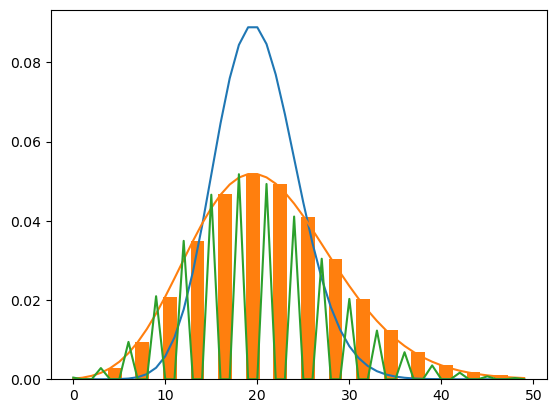

In [146]:
max_x = 50
x = np.arange(0, max_x, dtype=int)
beta = 1/3
l = 20
X = scipy.stats.poisson.rvs(beta*l, size=1000000) / beta
poisson = lambda x, l: scipy.stats.poisson.pmf(x, l)

# plt.hist(X, bins=30, width=.8, density=True)
h, bins = np.histogram(X, bins=np.arange(0,max_x,1/beta), density=True)
# bins += 1e-3
plt.bar((bins[1:]+bins[:-1])/2, h, width=(bins[1:]-bins[:-1])/2, color='C1')
plt.plot(x, poisson(x, l))
temp = poisson(x, l)**beta
plt.plot(x, temp/temp.sum())
temp = poisson(beta*x, beta*l)
plt.plot(x, np.minimum(beta, 1)*temp/temp.sum())